# Análise exploratório dos dados referentes às operações de crédito de estados e municípios no período de 2002-2018.

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
import re
from IPython.display import display, HTML
%matplotlib inline
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import os

In [2]:
# Dados: http://dados.gov.br/dataset/operacoes-copem
df = pd.read_csv('./SADIPEMCONSULTAPUBLICAGERALBATCH19122018.csv', sep=';', encoding = "ISO-8859-1")

In [3]:
df.head()

,Interessado,UF,Tipo de interessado,Tipo de operação,Finalidade,Tipo de credor,Credor,Moeda,Valor,Número do Processo/PVL,Código IBGE,Status,Data,Analisado por
0,Abadia dos Dourados,MG,Município,Operação Contratual Interna,Provias 2009,Instituição Financeira Nacional,Caixa Econômica Federal,Real,"300.000,00",00000.000000/0021-94,3100104.00,Devolvido,19/08/2009,STN
1,Abadia dos Dourados,MG,Município,Operação Contratual Interna,Caminho da Escola,Instituição Financeira Nacional,Caixa Econômica Federal,Real,"172.700,00",17944.000104/2008-22,3100104.00,Arquivado,17/04/2008,STN
2,Abadia dos Dourados,MG,Município,Operação Contratual Interna,Provias 2009,Instituição Financeira Nacional,Caixa Econômica Federal,Real,"300.000,00",17944.000953/2009-67,3100104.00,Deferido,20/11/2009,STN
3,Abadia dos Dourados,MG,Município,Operação Contratual Interna,Caminho da Escola 2009 A,Instituição Financeira Nacional,Caixa Econômica Federal,Real,"187.200,00",17944.001037/2009-44,3100104.00,Deferido,20/11/2009,STN
4,Abadia dos Dourados,MG,Município,Operação Contratual Interna,"Aquisição de máquinas, equipamentos e veículos",Instituição Financeira Nacional,Banco de Desenvolvimento de Minas Gerais S/A,Real,"1.000.000,00",17944.001324/2013-31,3100104.00,Deferido,06/11/2013,STN


### Tratando os dados

In [4]:
# Separa mês e ano, descarta dia
df['Mes'] = df['Data'].apply(lambda x: x[3:5])
df['Ano'] = df['Data'].apply(lambda x: x[-4:])
df.drop('Data', axis=1, inplace=True)

# Assumindo que a média do dólar e euro entre 2002 e 2018 é de 3 e 3.8 reais, respectivamente:
df['Valor'] = df['Valor'].apply(lambda x: int(x.replace('.', '')[:-3]))
df = df[(df['Moeda'] == 'Real') | (df['Moeda'] == 'Dólar dos EUA') | (df['Moeda'] == 'Euro')]
df.loc[df['Moeda'] == 'Dólar dos EUA', 'Valor'] = df[df['Moeda'] == 'Dólar dos EUA']['Valor'] * 3
df.loc[df['Moeda'] == 'Euro', 'Valor'] = df[df['Moeda'] == 'Euro']['Valor'] * 3.8

#
df.drop('Número do Processo/PVL', axis=1, inplace=True)

### 1) Número de solicitações de crédito deferidas por UF (2002 - 2018)

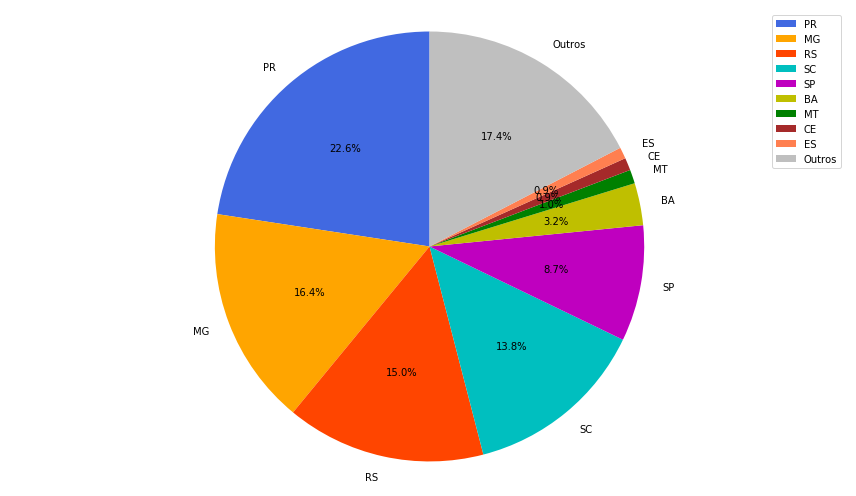

In [6]:
n_states = 9

#Somente transações deferidas
df_deferido = df[(df['Status'] == 'Deferido') | (df['Status'] == 'Deferido (PVL-IF)')]

outros = sum(df['UF'].value_counts()[n_states:].values)

cores = ['royalblue', 'orange', 'orangered', 'c', 'm', 'y', 'g', 'brown', 'coral', '0.75']
df_credito = pd.DataFrame({
    'Numero': np.append(df_deferido['UF'].value_counts()[:n_states].values, outros),
    'UF': list(df_deferido['UF'].value_counts()[:n_states].index) + ['Outros'],
    'cores': cores
})

fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(df_credito['Numero'], labels=df_credito['UF'], autopct='%1.1f%%', colors=df_credito['cores'], startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.legend()
plt.show()

### 2) Porcentagem do total de crédito solicitado por cada UF entre 2002-2018

In [7]:
agg = df_deferido.groupby('UF').agg({'Valor': 'sum'})
agg.columns = pd.Index(['Soma dos valores'])
outros = np.sum(agg.loc[[i for i in agg.index.tolist() if i not in df_credito['UF']]].values)
df_credito = df_credito.join(agg, on='UF', how='left')
df_credito.loc[df_credito['UF'] == 'Outros', 'Soma dos valores'] = outros

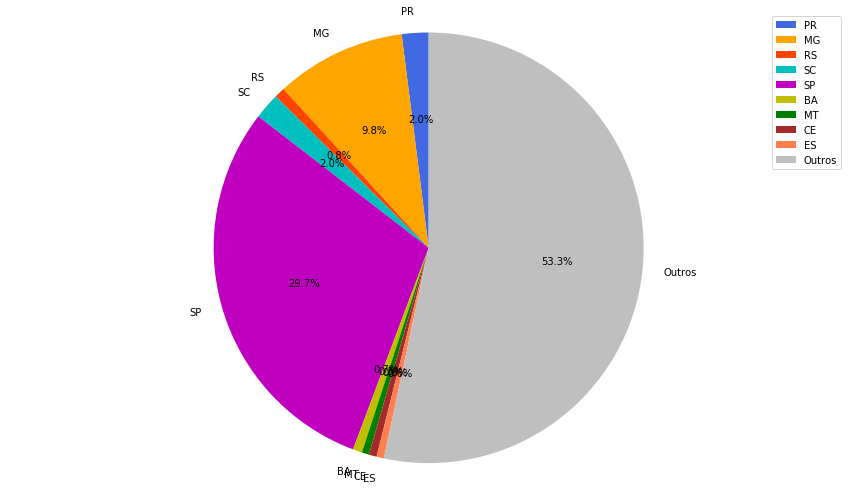

In [8]:
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(df_credito['Soma dos valores'], labels=df_credito['UF'], autopct='%1.1f%%', colors=df_credito['cores'], startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.legend()
plt.show()

Repare que um alto número de operações de crédito não necessariamente implica em alto valor circulado. Paraná, por exemplo, é responsável por 22.6% das operações de crédito, mas somente 3.8% do dinheiro circulado. São Paulo, por outro lado, é responsável por somente 8.7% destas operações, mas estas correspondam a 56.1% do total de crédito. Dividindo o total de crédito pelo número de operações, teremos a média do valor de crédito por operação:

### 3) Média do valor de crédito por operação

Text(0,0.5,'Valor médio de crédito por operação')

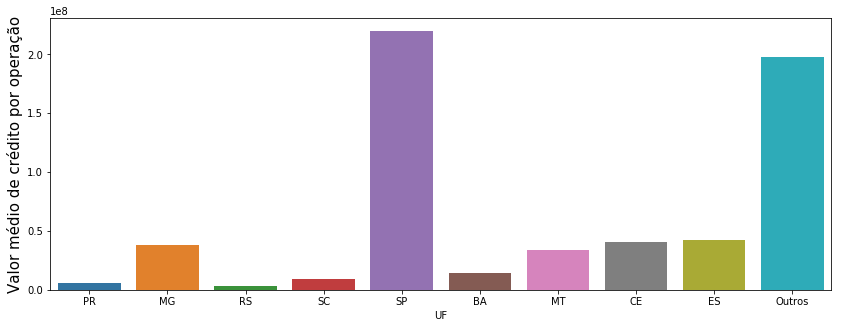

In [9]:
_, ax = plt.subplots(figsize=(14,5))
sns.barplot(x=df_credito['UF'], y=df_credito['Soma dos valores']/df_credito['Numero'])
ax.set_ylabel('Valor médio de crédito por operação', fontsize=15)

Valor médio de crédito por operação de SP está estranhamente alto. Vamos ver qual a distribuição por ano:

### 4) Média dos valores de crédito das operações deferidas de São Paulo por ano

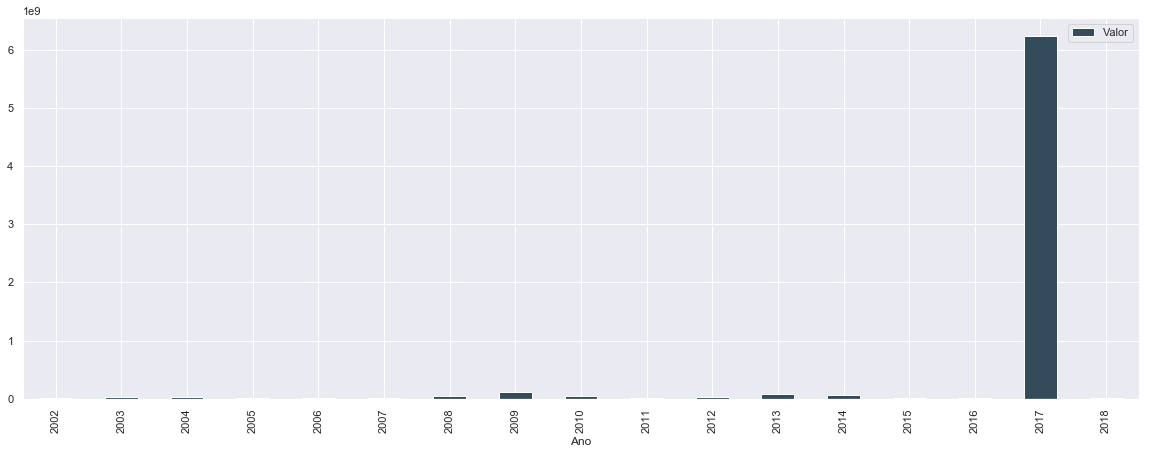

In [45]:
df_sp = df_deferido[df_deferido['UF'] == 'SP'].groupby('Ano').agg({'Valor': 'mean'})
df_sp.plot.bar(figsize=(20,7))

É, realmente, há uma enorme discrepância entre todos os anos e 2017. Será que há algum erro no valor das operações nos dados? Ou 2017 está sobrerepresentado para o estado de SP? Ou há alguma outra explicação política ou socio-econômica?

### 5) Status das operações

In [26]:
por_op = df.groupby('UF')['Status'].value_counts().unstack(fill_value=0)
por_op = pd.DataFrame({
    'Deferido': por_op['Deferido'] + por_op['Deferido (PVL-IF)'],
    'Outros': por_op.drop(['Deferido', 'Deferido (PVL-IF)'], axis=1).sum(axis=1)
})

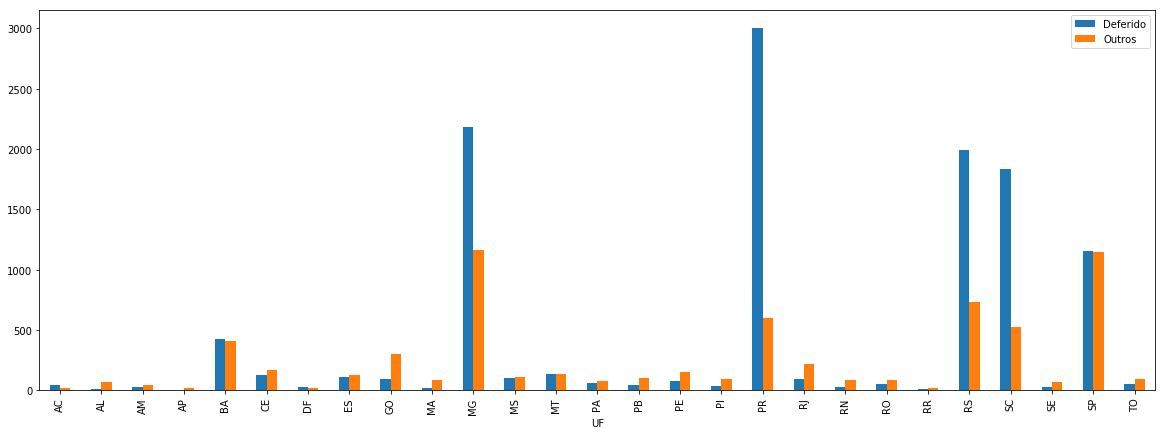

In [30]:
por_op.plot.bar(figsize=(20,7))

### 6) 10 maiores finalidades das operações de crédito por valor total

In [31]:
op_cr = df.groupby('Finalidade').agg({'Valor': 'sum'}).sort_values(ascending=False, by='Valor')[:10]
op_cr = op_cr.reset_index()

,Finalidade,Valor
0,Renegociação de dívidas,412708660763.00
1,Infraestrutura,160114964949.20
2,Multissetorial,43171812824.00
3,Reestruturação e recomposição do principal de ...,25744015726.00
4,Proinveste,20097700002.00
5,Desenvolvimento sustentável,19024248150.00
6,Fortalecimento Institucional,18200915927.00
7,PAC - Saneamento - 2009 A,17715616267.00
8,PAC 2 - Pró-Transporte - Pavimentação e Qualif...,16101039496.00
9,Concessão de garantia a empresa estatal não de...,11319159888.00


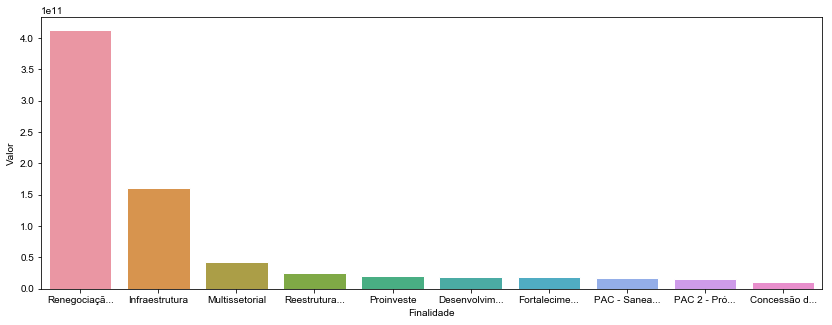

In [32]:
plt.subplots(figsize=(14,5))
sns.set(style='darkgrid', palette="Blues_d")

display(op_cr)

def clean_name(x):
    if len(x) <= 14:
        return x
    else:
        return x[:11] + '...'

op_cr['Finalidade'] = op_cr['Finalidade'].apply(clean_name)
sns.barplot(x='Finalidade', y='Valor', data=op_cr)
pd.options.display.width = None